## Load Environments

In [1]:
import warnings; warnings.filterwarnings('ignore')
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, ParameterGrid

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.regularizers import l2 

Using TensorFlow backend.


## Read in raw data sets, training, tournament (val, test, live)

In [4]:
def import_data_sets():
    train = pd.read_csv('numerai_training_data.csv', index_col=0).drop('data_type', axis=1)
    df = pd.read_csv('numerai_tournament_data.csv', index_col=0)
    valid = df.loc[df['data_type']=='validation'].drop('data_type', axis=1)
    test = df.loc[df['data_type']=='test'].drop('data_type', axis=1)
    live = df.loc[df['data_type']=='live'].drop('data_type', axis=1)
    return(train, valid, test, live)

In [5]:
train, valid, test, live = import_data_sets()

In [6]:
train.head()

,era,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,target
id,,,,,,,,,,,,,,,,,,,,,
n5e99b4326e6f463,era1,0.64488,0.56167,0.72591,0.52219,0.49311,0.51511,0.45514,0.51007,0.56489,...,0.67751,0.43340,0.67009,0.50086,0.51208,0.58674,0.54358,0.58602,0.51818,0
ncf8fb21f31e74d8,era1,0.44203,0.42957,0.51861,0.38445,0.62049,0.49168,0.46444,0.54369,0.52228,...,0.44734,0.47049,0.50980,0.57241,0.38253,0.52020,0.55781,0.55142,0.51869,1
n834cd2712b7e479,era1,0.36741,0.43188,0.52491,0.44392,0.52592,0.50014,0.32131,0.62067,0.49516,...,0.39102,0.71896,0.57458,0.50981,0.52993,0.53588,0.52843,0.50573,0.38799,1
nf49d82d23f17475,era1,0.80707,0.56341,0.52526,0.66020,0.34807,0.64373,0.68063,0.50475,0.64483,...,0.54288,0.39457,0.61531,0.30979,0.51926,0.44679,0.45668,0.66750,0.60906,1
n7586ede71dd04e7,era1,0.35577,0.57219,0.61766,0.42305,0.49314,0.49894,0.61066,0.40629,0.59973,...,0.48323,0.56839,0.59356,0.41716,0.51963,0.48346,0.52642,0.47278,0.43362,1


In [7]:
era1 = train.loc[train.era=="era1"]
era2 = train.loc[train.era=="era2"]

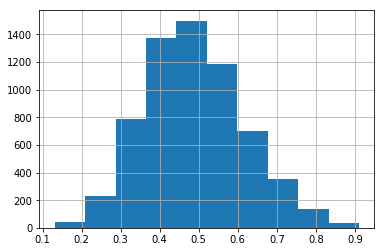

In [15]:
era1.feature4.hist()
plt.show()

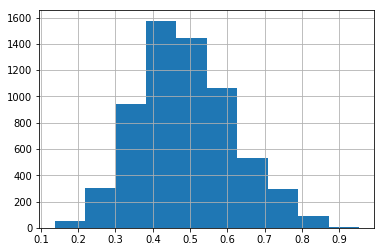

In [16]:
era2.feature4.hist()
plt.show()

In [7]:
feature_cols = [f for f in train.columns if "feature" in f]

In [15]:
x_train = train[feature_cols]
x_val = valid[feature_cols]
x_test = test[feature_cols]
x_live = live[feature_cols]
y_train = train['target']
y_val = valid['target']


train_eras = train['era'].values
val_eras = valid['era'].values

In [9]:
def score_keras_model(model, x_val, y_val, eras):    
    
    print('Logloss: ' + str(log_loss(y_val.values, mod.predict_proba(x_val_pca))))
    
    val_logo = LeaveOneGroupOut()
    scores = []
    fail = 0
    guessing = -log(.5)
    
    for _, index in val_logo.split(x_val, y_val, eras):
        score = log_loss(y_val.iloc[index].values, model.predict(x_val.values[index,:]))
        print(score)
        if(score > guessing):
            fail += 1
            
    print(fail / 12.0)

## KMeans Clustering

In [11]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(x_train)

In [16]:
x_train['cluster'] = kmeans.predict(x_train)
x_val['cluster'] = kmeans.predict(x_val)
x_test['cluster'] = kmeans.predict(x_test)
x_live['cluster'] = kmeans.predict(x_live)

In [20]:
x_train['cluster'].value_counts()

3    49807
1    27085
2    17411
0    14102
Name: cluster, dtype: int64

In [21]:
x_val['cluster'].value_counts()

3    7363
1    4510
2    2645
0    2168
Name: cluster, dtype: int64

In [22]:
x_test['cluster'].value_counts()

3    13130
1     6962
2     4352
0     3249
Name: cluster, dtype: int64

In [23]:
x_live['cluster'].value_counts()

3    528
1    332
2    232
0    188
Name: cluster, dtype: int64

## Keras Model

In [25]:
def compile_nn(input_dim):
    
    model = Sequential()    
    model.add(Dense(24, input_dim=input_dim, activation='relu', init='normal', W_regularizer=l2(0.001)))    
    model.add(Dropout(0.3))
    
    for i in range(0,4):        
        model.add(Dense(128, activation='relu', init='normal', W_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [26]:
nets = []
nn1 = compile_nn(x_train.shape[1])
nn2 = compile_nn(x_train.shape[1])
nn3 = compile_nn(x_train.shape[1])
nn4 = compile_nn(x_train.shape[1])
nets.append(nn1)
nets.append(nn2)
nets.append(nn3)
nets.append(nn4)

In [28]:
fits = []
for i in range(0,4):
    nn = nets[i]
    
    xt = x_train.loc[x_train['cluster']==i].values
    yt = y_train.loc[x_train['cluster']==i].values
    xv = x_val.loc[x_val['cluster']==i].values
    yv = y_val.loc[x_val['cluster']==i].values
    
    nn.fit(xt, yt, validation_data=(xv, yv),
           nb_epoch=10, batch_size=256, verbose=1)
    
    fits.append(nn)

Train on 14102 samples, validate on 2168 samples
Epoch 1/10
14102/14102 [==============================] - 1s - loss: 0.7418 - acc: 0.5089 - val_loss: 0.7064 - val_acc: 0.5148
Epoch 2/10
14102/14102 [==============================] - 0s - loss: 0.6982 - acc: 0.5121 - val_loss: 0.6937 - val_acc: 0.5148
Epoch 3/10
14102/14102 [==============================] - 0s - loss: 0.6932 - acc: 0.5119 - val_loss: 0.6928 - val_acc: 0.5148
Epoch 4/10
14102/14102 [==============================] - 0s - loss: 0.6930 - acc: 0.5119 - val_loss: 0.6928 - val_acc: 0.5148
Epoch 5/10
14102/14102 [==============================] - 0s - loss: 0.6929 - acc: 0.5120 - val_loss: 0.6928 - val_acc: 0.5148
Epoch 6/10
14102/14102 [==============================] - 0s - loss: 0.6929 - acc: 0.5119 - val_loss: 0.6928 - val_acc: 0.5148
Epoch 7/10
14102/14102 [==============================] - 0s - loss: 0.6929 - acc: 0.5119 - val_loss: 0.6927 - val_acc: 0.5148
Epoch 8/10
14102/14102 [==============================] - 0s -

In [43]:
df_pred = x_val

for i in range(0,4):
    nn = nets[i]
    p = nn.predict(x_val.loc[x_val['cluster']==i].values)
    df_pred['pred'].loc[x_val['cluster']==i] = p
    
df_pred.head()    

KeyError: 'pred'

In [53]:
score_keras_model(nn, x_val, y_val, val_eras)

Logloss: 0.693223366556
0.693122177049
0.693196973545
0.692975956408
0.693058342165
0.693136847739
0.692947238747
0.693346140927
0.693254197692
0.693596618931
0.693635535614
0.693149273616
0.693251757821
0.583333333333


## Submission

In [39]:
to_pred = pd.concat([x_val,test,live])

#Keras model
nn_preds = pd.Series(nn.predict(to_pred.values)[:,0])

#to_vote = pd.concat([rf_1_preds, rf_2_preds], axis=1)

# Ensemble Tree
#ens_preds = pd.Series(tree.predict_proba(to_vote.values)[:,1])
#ens_preds = to_vote.mean(axis=1)
ens_preds = nn_preds

In [40]:
ens_preds.describe()

count    45630.000000
mean         0.503124
std          0.004284
min          0.498657
25%          0.499918
50%          0.502135
75%          0.505005
max          0.534094
dtype: float64

In [33]:
sub = pd.concat([pd.Series(to_pred.index), pd.Series(ens_preds)], axis=1)
sub.columns = ['id', 'probability']
sub.head()

,id,probability
0,96144,0.517328
1,17982,0.523370
2,96161,0.486145
3,53895,0.494751
4,7267,0.510167


In [34]:
sub.to_csv('sub_62_1_rf.csv', index=False)